# **2. Behavioral Statistics**

Jupyter notebook for performing basic statistical analyses on the **population demographics and event-related information**.

Includes group comparisons between healthy controls (HCs) and people with MS (PwMS).

Additionally, includes group comparisons between PwMS who (don't) take Benzodiazepines medication as part of treatment (BZDp vs. BZDn).

### **Required input files/folders to run this Notebook**:
- **parceled_dataset_dir**: folder with all fully processed .fif files (from Notebook 1. Preprocessing MEG Python) --> Needed in order to extract event timestamps
- **paths_event_dfs**: folder with the csv files containing the event-related information (1 seperate file per subject)
- **subjectinfo.mat**: file with all clinical patient information 

#### **Import needed packages**

In [1]:
import os
import glob
import numpy
import mne
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from statistics import mean
import itertools
from itertools import chain

import scipy
from scipy.io import loadmat
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
import scipy.stats as stats

### Load in dataset - fullly processed .fif files for all patients

In [2]:
# Folder path with all fully processed .fif files
parceled_dataset_dir = "/home/olivierb/FULLY_PROCESSED/processed_WITHOUT_orth/"

all_fif_files = sorted(glob.glob(parceled_dataset_dir + '*.fif'))
print(len(all_fif_files))

wanted_sub_IDs = [subject[-12:-8] for subject in all_fif_files]

124


### Remove subjects that should be excluded

##### **<font color='red'>Important:** <font color='black'> For all post-processing analyses (Statistics, ERF, Functional Connectivity, HMM) we use the same final SDMT dataset after additional subject exclusions
   
##### **Final SDMT dataset = 110 subjects**

In [3]:
# Retained .fif files
fif_files = all_fif_files
print(len(fif_files))

# Retained indices
file_IDs_retained = wanted_sub_IDs

## Subjects indices to remove 
# The subjects excluded in the post-processing analyses relate to prior findings by: Master student Sarah Dierickx (2023), PhD student Fahimeh Akbarian from AIMS VUB. 
# As well as additional findings throughout this Thesis (Olivier Burta, 2024):
# - missing DIODE channel (in the event extraction step)
# - missing BUTTON press response channels
# - flat PSD-spectrum
subjects_to_exclude = [0, 5, 38, 41, 49, 62, 68, 83, 84, 106, 107, 114, 119,   # subjects with missing DIODE channel OR having less DIODE events than the amount of trials  
                       30]                                                     # subject with completely flat PSD spectrum -> not include
# Remove subjects
fif_files = []
for idx in range(len(all_fif_files)):
    if idx not in subjects_to_exclude:
        fif_files.append(all_fif_files[idx])
print(len(fif_files))

# Retained file IDs
file_IDs_retained = []
for idx in range(len(wanted_sub_IDs)):
    if idx not in subjects_to_exclude:
        file_IDs_retained.append(wanted_sub_IDs[idx])

print(len(file_IDs_retained))
print(file_IDs_retained)

124
110
110
['0925', '0944', '0945', '0947', '0987', '0992', '0995', '0997', '0999', '1000', '1001', '1002', '1005', '1006', '1007', '1008', '1009', '1010', '1017', '1018', '1023', '1024', '1025', '1028', '1031', '1033', '1052', '1053', '1073', '1078', '1082', '1097', '1106', '2096', '2102', '2121', '2122', '2144', '2147', '2150', '2151', '2163', '2164', '2169', '2172', '2173', '2179', '2189', '2190', '2192', '2193', '2201', '2203', '2206', '2211', '2215', '2220', '2221', '2224', '2226', '2227', '2235', '2238', '2239', '2241', '2252', '2257', '2264', '2266', '2267', '2268', '2277', '2278', '2279', '2292', '2300', '2305', '2306', '2311', '2312', '2313', '2314', '2317', '2318', '2319', '2324', '2325', '2327', '2328', '2341', '2342', '2343', '2346', '2359', '2363', '2364', '2378', '2379', '2384', '2386', '2388', '2396', '2410', '2414', '2416', '2421', '2427', '2440', '2447', '2448']


## **Load patientinfo file**

##### The patientinfo.mat file contains all sorts of patient information such as age, gender, patient type, scores from neuropsychological examinations, ...

In [4]:
# immediate access to patientinfo from all 150 patients of the original dataset (will have to remove patients to end up with 110)
from scipy.io import loadmat
import pandas as pd
import numpy as np

# Function to convert the patientinfo file from .mat format to a Pandas DataFrame
def patientinfo_to_df(patientinfo_mat_path):
    
    array = loadmat(patientinfo_mat_path)['subjectinfo'][0]
    
    # Only the relevant columns are kept
    indices_relevant_cols = [0,3,4,5,6,7,16,19,21,26]
    relevant_col_names = ['code', 'disdur', 'type', 'age', 'edu', 'SDMT', 'gender_isfemale', 'isms', 'EDSS', 'benzos']
    
    # for each of the relevant columns: extract the raw column
    extracted_out = []
    for column in range(len(indices_relevant_cols)):
        extracted_col = [array[patient][indices_relevant_cols[column]] for patient in range(len(array))]
        extracted_out.append(extracted_col)
    
    # For each column: Recursively unpack the values using unpack_nested()
    df_out = pd.DataFrame()
    for col in range(len(indices_relevant_cols)):
        df_out[relevant_col_names[col]] = extracted_out[col]
    
    # Recursively unpack value from nested arrays --> Needed because every column has a different amount of nested arrays used to story its elements
    def unpack_nested(val):
        if isinstance(val, np.ndarray):
            return unpack_nested(val[0])
        else:
            return val
                    
    df_out = df_out.map(unpack_nested)
    
    return df_out

In [5]:
# Get a Pandas DataFrame with the patientinfo for all subjects
df_patientinfo = patientinfo_to_df("/home/olivierb/Downloads/subjectinfo.mat")

In [ ]:
from IPython.display import display
display(df_patientinfo)

Only keep the **110 patients** with valid MEG and MRI data (out of 150)

In [ ]:
df_filtered =  df_patientinfo.loc[df_patientinfo['code'].isin(file_IDs_retained)].reset_index(drop=True)
display(df_filtered)

### Split data into groups:
- Controls
- MS subjects
- MS subjects (with BZDs)
- MS subjects (without BZDs)

In [8]:
# The dataframes for each group
df_control = df_filtered.loc[df_filtered['isms'] == 0].reset_index(drop=True)
df_ms = df_filtered.loc[df_filtered['isms'] == 1].reset_index(drop=True) 
df_ms_yes_bzds = df_ms.loc[df_ms['benzos'] == 1].reset_index(drop=True) 
df_ms_no_bzds = df_ms.loc[df_ms['benzos'] == 0].reset_index(drop=True)

# List of indices for each group (easy split of all eventtables into groups)
IDs_control = df_filtered.loc[df_filtered['isms'] == 0].index.tolist()
IDs_ms = df_filtered.loc[df_filtered['isms'] == 1].index.tolist()
IDs_ms_yes_bzds = df_filtered.loc[df_filtered['benzos'] == 1].index.tolist()
IDs_ms_no_bzds = df_filtered.loc[(df_filtered['isms'] == 1) & (df_filtered['benzos'] ==0)].index.tolist()

# Just to verify that there are no duplicates in the list of indices
all_IDs = IDs_control + IDs_ms_yes_bzds + IDs_ms_no_bzds
print(len(all_IDs))
check = (len(set(all_IDs)) == len(all_IDs))
if check:
    print('All good')
else:
    print('Something wrong')

110
All good


# **Basic Demographics and Group comparisons**

In [18]:
# Function to obtain Demographics for a specific group type within the studied sample
def get_basic_statistics(dataframe_group, group_type, group_name):
    
    print(group_name)

    N_subjects = len(dataframe_group)
    print('N:', N_subjects)

    percent_female = len(dataframe_group.loc[dataframe_group['gender_isfemale'] == 1])/len(dataframe_group)*100
    print('% female:', round(percent_female,2))

    mean_age,std_age = dataframe_group['age'].mean(), dataframe_group['age'].std()
    print('age:', round(mean_age,2), '+/-', round(std_age,2))

    mean_edu,std_edu = dataframe_group['edu'].mean(), dataframe_group['edu'].std()
    print('education:', round(mean_edu,2), '+/-', round(std_edu,2))

    mean_sdmt,std_sdmt = dataframe_group['SDMT'].mean(), dataframe_group['SDMT'].std()
    print('SDMT-score:', round(mean_sdmt,2), '+/-', round(std_sdmt,2))

    if group_type == 'ms':
        mean_disdur,std_disdur = dataframe_group['disdur'].mean(), dataframe_group['disdur'].std()
        print('disease duration:', round(mean_disdur,2), '+/-', round(std_disdur,2))
    
        mean_EDSS,std_EDSS = dataframe_group['EDSS'].mean(), dataframe_group['EDSS'].std()
        print('EDSS:', round(mean_EDSS,2), '+/-', round(std_EDSS,2))
    
        return dataframe_group['gender_isfemale'], dataframe_group['age'], dataframe_group['edu'], dataframe_group['SDMT'], dataframe_group['disdur'], dataframe_group['EDSS']
    
    else:
        # variables for which I want to do group comparison
        return dataframe_group['gender_isfemale'], dataframe_group['age'], dataframe_group['edu'], dataframe_group['SDMT']

#### **HCs vs. MS**

In [19]:
control_outcomes = get_basic_statistics(df_control, 'control', 'Controls')

Controls
N: 37
% female: 59.46
age: 47.38 +/- 11.82
education: 15.16 +/- 2.22
SDMT-score: 54.51 +/- 9.4


In [20]:
ms_outcomes = get_basic_statistics(df_ms, 'ms', 'All MS patients')

All MS patients
N: 73
% female: 73.97
age: 48.17 +/- 9.86
education: 13.79 +/- 2.73
SDMT-score: 48.6 +/- 10.74
disease duration: 16.66 +/- 9.78
EDSS: 3.22 +/- 1.49


### Compare group differences (gender, age, education, SDMT)

In [21]:
# Function to verify an important assumption before conducting a chi²-test: The EXPECTED value of cells should be 5 or greater in at least 80% of cells
# For a 2x2-table: count should be > 5 for all cells
def verify_chi2_assumption(contingency_table):
    
    expected_table = np.zeros(np.shape(contingency_table))
    # Sum of all cells
    total_sum = np.sum(contingency_table)
    
    # For each cell, calculate the expected value using the observed contingency table
    for row in range(len(contingency_table)):
        for col in range(len(contingency_table[row])):
            expected_table[row, col] = (np.sum(contingency_table[row]) * np.sum(contingency_table[col]))/total_sum
    
    return expected_table

In [22]:
# dichotomous --> Need to create contingency table first
#             --> And then use chi² test

### GENDER
from scipy.stats import chi2_contingency

# Counting females (1) and males (0) in each group
females_males_control = [control_outcomes[0].tolist().count(1), control_outcomes[0].tolist().count(0)]
females_males_ms = [ms_outcomes[0].tolist().count(1), ms_outcomes[0].tolist().count(0)]

# Constructing the contingency table
contingency_table = np.array([females_males_control, females_males_ms])
print('OBSERVED contingency table')
print(['female control', 'male control'])
print(['female ms', 'male ms'])
print(contingency_table)

## Verify assumption for chi²
print('EXPECTED contingency table')
print(verify_chi2_assumption(contingency_table))

# Perform the chi² test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'gender: {p_value}')

### AGE
from scipy.stats import mannwhitneyu
_, p_value = mannwhitneyu(control_outcomes[1].tolist(), ms_outcomes[1].tolist()) 
print(f'age: {p_value}')

### EDU
_, p_value = mannwhitneyu(control_outcomes[2].tolist(), ms_outcomes[2].tolist()) 
print(f'education: {p_value}')

### SDMT
_, p_value = mannwhitneyu(control_outcomes[3].tolist(), ms_outcomes[3].tolist())
print(f'SDMT-score: {p_value}')

OBSERVED contingency table
['female control', 'male control']
['female ms', 'male ms']
[[22 15]
 [54 19]]
EXPECTED contingency table
[[12.44545455 24.55454545]
 [24.55454545 48.44545455]]
gender: 0.18093502023120994
age: 0.8445138917681718
education: 0.00509921766934455
SDMT-score: 0.006983664835491482


### **BZDp vs. BZDn**

In [23]:
bzdp_outcomes = get_basic_statistics(df_ms_yes_bzds, 'ms', 'MS with BZDs')

MS with BZDs
N: 18
% female: 100.0
age: 48.07 +/- 7.97
education: 13.06 +/- 2.58
SDMT-score: 47.11 +/- 7.51
disease duration: 13.39 +/- 6.77
EDSS: 3.75 +/- 1.13


In [24]:
bzdn_outcomes = get_basic_statistics(df_ms_no_bzds, 'ms', 'MS without BZDs')

MS without BZDs
N: 55
% female: 65.45
age: 48.2 +/- 10.47
education: 14.04 +/- 2.76
SDMT-score: 49.09 +/- 11.62
disease duration: 17.73 +/- 10.41
EDSS: 3.05 +/- 1.56


### Compare group differences (gender, age, education, SDMT)

In [25]:
# dichotomous --> Need to create contingency table first
#             --> And then use chi² test

### GENDER

# Counting females (1) and males (0) in each group
females_males_bzdp = [bzdp_outcomes[0].tolist().count(1), bzdp_outcomes[0].tolist().count(0)]
females_males_bzdn = [bzdn_outcomes[0].tolist().count(1), bzdn_outcomes[0].tolist().count(0)]
# Constructing the contingency table
contingency_table = np.array([females_males_bzdp, females_males_bzdn])
print('OBSERVED contingency table')
print(['female bzdp', 'male bzdp'])
print(['female bzdn', 'male bzdn'])
print(contingency_table)

## Verify assumption for chi²
print('EXPECTED contingency table')
print(verify_chi2_assumption(contingency_table))

# Perform the chi-square test
#chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
#print(f'gender: {p_value}')

## Need an alternative test because chi²-test is not valid (count in one of the cells < 5) --> All BZDp are females!
# use Fisher exact test
_, p_value = scipy.stats.fisher_exact(contingency_table)
print(f'gender: {p_value}')

### AGE
_, p_value = mannwhitneyu(bzdp_outcomes[1].tolist(), bzdn_outcomes[1].tolist()) 
print(f'age: {p_value}')

### EDU
_, p_value = mannwhitneyu(bzdp_outcomes[2].tolist(), bzdn_outcomes[2].tolist()) 
print(f'education: {p_value}')

### SDMT
_, p_value = mannwhitneyu(bzdp_outcomes[3].tolist(), bzdn_outcomes[3].tolist())
print(f'SDMT-score: {p_value}')

### Diseqse durqtion
_, p_value = mannwhitneyu(bzdp_outcomes[4].tolist(), bzdn_outcomes[4].tolist())
print(f'dISEASE DUR.: {p_value}')

### EDSS
_, p_value = mannwhitneyu(bzdp_outcomes[5].tolist(), bzdn_outcomes[5].tolist())
print(f'edss: {p_value}')

OBSERVED contingency table
['female bzdp', 'male bzdp']
['female bzdn', 'male bzdn']
[[18  0]
 [36 19]]
EXPECTED contingency table
[[ 4.43835616 13.56164384]
 [13.56164384 41.43835616]]
gender: 0.003779100050448785
age: 0.9438821035067758
education: 0.26439357512338213
SDMT-score: 0.4851199307502728
dISEASE DUR.: 0.10658718957980033
edss: 0.03970097875759516


## Properly load events for all patients (Events extracted **from Python raw.fif** in Notebook 3. ERF Analysis, stored in .csv files per subject)

#### <font color='red'>**Note**: <font color='black'> Select only the **first 128 trials**

In [37]:
# Load all dataframes containing the events, for each subject
# => To find the corresponding eventtables of each group, can simply find the rows in the original df_filtered 

# Get all paths for the .csv files containing all event-related information per subject
paths_event_dfs = sorted(glob.glob("/home/olivierb/MEG_events/Python_DIODE/event_df_*"))

# Read all csv's as Pandas DataFrames, and only retain the first 128 trials for each subject
all_subject_dfs = [pd.read_csv(subject_events)[0:128] for subject_events in paths_event_dfs]

In [38]:
# Example of a DataFrame for 1 subject
print(all_subject_dfs[0])

     Unnamed: 0       trial_type  epoch_time  duration         response_type  \
0             0  trial_incorrect      14.072     5.480  trial_incorrect_r_ok   
1             1    trial_correct      19.592     3.928    trial_correct_r_ok   
2             2    trial_correct      23.556     3.740    trial_correct_r_ok   
3             3  trial_incorrect      27.336     4.236  trial_incorrect_r_ok   
4             4    trial_correct      31.600     3.608    trial_correct_r_ok   
..          ...              ...         ...       ...                   ...   
123         123    trial_correct     624.272     3.724    trial_correct_r_ok   
124         124  trial_incorrect     628.016     4.632  trial_incorrect_r_ok   
125         125  trial_incorrect     632.684     3.868  trial_incorrect_r_ok   
126         126  trial_incorrect     636.580     5.008  trial_incorrect_r_ok   
127         127  trial_incorrect     641.616     3.864  trial_incorrect_r_ok   

     reaction_time  epoch_button_time  

#### Visualisation: see how the trials are distributed within the 128 first ones

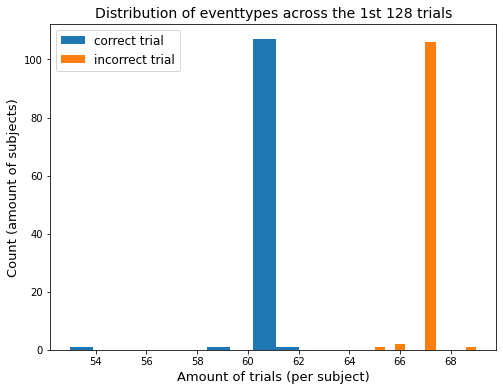

In [39]:
import matplotlib.pyplot as plt
amount_correct = [len(subject.loc[subject['trial_type'] == 'trial_correct']) for subject in all_subject_dfs]
amount_incorrect = [len(subject.loc[subject['trial_type'] == 'trial_incorrect']) for subject in all_subject_dfs]

plt.figure(figsize=(8,6))
plt.hist(amount_correct, label='correct trial')
plt.hist(amount_incorrect, label='incorrect trial')
plt.title('Distribution of eventtypes across the 1st 128 trials',fontsize=14)
plt.ylabel('Count (amount of subjects)',fontsize=13)
plt.xlabel('Amount of trials (per subject)', fontsize=13)
plt.legend(fontsize=12)

## Get **succes rate** for each group

In [40]:
# Function to obtain the succes rate, a measure for the subject's performance during the computerised SDMT
def get_succes_rates(all_dfs, IDs_group):
    
    succes_rates = []
    for subject in IDs_group:
        
        df_subject = all_dfs[subject]
        
        # only for subjects with events in their eventtable
        if len(df_subject) != 0:
            # Count the total amount of events where the subject responded correctly ('r_ok')
            corrects = len(df_subject.loc[(df_subject['trial_type'] == 'trial_correct') & (df_subject['response_type'] == 'trial_correct_r_ok')])
            wrongs = len(df_subject.loc[(df_subject['trial_type'] == 'trial_incorrect') & (df_subject['response_type'] == 'trial_incorrect_r_ok')])
            succes_rate = (corrects + wrongs)/len(df_subject)*100
            succes_rates.append(succes_rate)
    
    return succes_rates

sr_control = get_succes_rates(all_subject_dfs,IDs_control)
sr_ms = get_succes_rates(all_subject_dfs,IDs_ms)
sr_ms_yes_bzds = get_succes_rates(all_subject_dfs,IDs_ms_yes_bzds)
sr_ms_no_bzds = get_succes_rates(all_subject_dfs,IDs_ms_no_bzds)

sr_allgroups = [sr_control, sr_ms, sr_ms_yes_bzds,sr_ms_no_bzds]

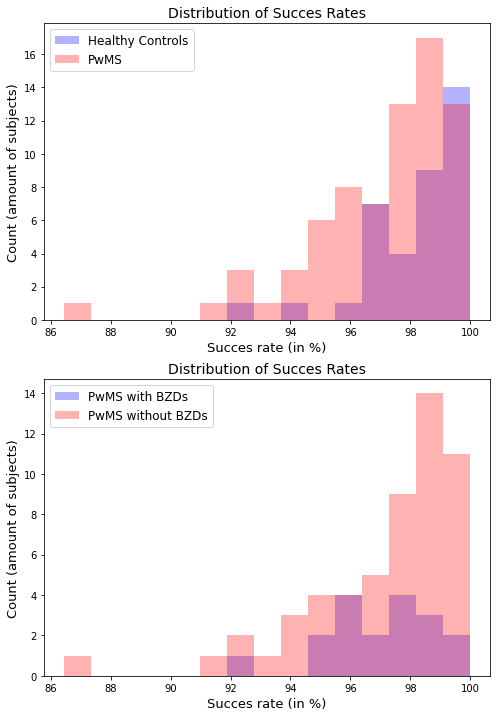

In [42]:
import matplotlib.pyplot as plt

num_cases = 2

fig, axes = plt.subplots(nrows=num_cases, ncols=1, figsize=(8, 6*num_cases))

group_names = ['Healthy Controls', 'PwMS', 'PwMS with BZDs', 'PwMS without BZDs']
for i in range(num_cases):
    ax = axes[i]
    
    data_group1 = sr_allgroups[2*i]
    data_group2 = sr_allgroups[2*i + 1]
    
    # Combine the data to determine the overall range and number of bins
    combined_data = np.concatenate([data_group1, data_group2])
    bin_range = (combined_data.min(), combined_data.max())
    num_bins = 15  # Adjust the number of bins as needed
    
    # Plot the histogram for OPEN EYES
    ax.hist(data_group1, bins=num_bins, range=bin_range, color='blue', alpha=0.3, label = group_names[2*i])
    ax.hist(data_group2, bins=num_bins, range=bin_range, color='red', alpha=0.3, label = group_names[2*i + 1])
    # Set labels and title for the subplot
    ax.set_xlabel('Succes rate (in %)', fontsize=13)
    ax.set_ylabel('Count (amount of subjects)', fontsize=13)
    ax.set_title('Distribution of Succes Rates', fontsize=14)
    ax.legend(fontsize=12)
    

In [144]:
import scipy.stats as stats

#### Controls vs. MS
print('Controls vs. MS')
print('Control:', np.mean(sr_control), '+/-', np.std(sr_control))
print('MS:', np.mean(sr_ms), '+/-', np.std(sr_ms))
# Mann-Whitney U-test
_, p_value = mannwhitneyu(sr_control, sr_ms) 
print('p:', p_value)
p_value_HC_PwMS = np.round(p_value,5)

print('----------------------------')

#### MS yes BZDs vs. MS no BZDs
print('MS yes vs. no  BZDs')
print('MS yes BZDs:', np.mean(sr_ms_yes_bzds), '+/-', np.std(sr_ms_yes_bzds))
print('MS no BZDs:', np.mean(sr_ms_no_bzds), '+/-', np.std(sr_ms_no_bzds))
# Mann-Whitney U-test
_, p_value = mannwhitneyu(sr_ms_yes_bzds, sr_ms_no_bzds) 
print('p:', p_value)

Controls vs. MS
Control: 98.14189189189189 +/- 1.6780672708028317
MS: 97.05219877593517 +/- 2.330953859930436
p: 0.006957949201890116
----------------------------
MS yes vs. no  BZDs
MS yes BZDs: 97.00520833333333 +/- 1.7323092051627695
MS no BZDs: 97.06757746624123 +/- 2.4956885865317453
p: 0.40728579037372004


/tmp/ipykernel_2753138/3470604151.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_boxplot.append(np.array([data[plot][0],


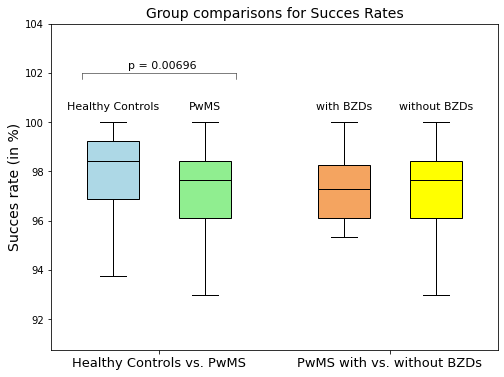

In [154]:
# Make a plot with boxplots to show the results + stat. sign. between HC & PwMS
data = [[sr_control, sr_ms], [sr_ms_yes_bzds,sr_ms_no_bzds]]
number_plots = len(data)

x = [750*(i+1) for i in range(number_plots)]

data_boxplot = []
for plot in range(number_plots):
    data_boxplot.append(np.array([data[plot][0], 
                                 data[plot][1]]).T)
    
plt.figure(figsize=(4*number_plots,6))
labels = ['Healthy Controls', 'PwMS', 'with BZDs', 'without BZDs']   

boxes = []
for plot in range(number_plots):
    # Plot boxplots with different colors and labels
    if plot < 1:
        box = plt.boxplot(data_boxplot[plot], 0, '', positions=[x[plot]-150, x[plot]+150], widths=170, patch_artist=True)
        boxes.append(box)
    else:
        box = plt.boxplot(data_boxplot[plot], 0, '', positions=[x[plot]-150, x[plot]+150], widths=170, patch_artist=True)
        boxes.append(box)

# Find max value between the 2 groups, needed to plot the p_value above at a good height
max_vals = [[item.get_ydata()[1] for item in box['whiskers']][1] for box in boxes]

# Find overall min & max value, so that the total y height of the plot can be chosen accordingly
min_val = np.min([[item.get_ydata()[1] for item in box['whiskers']][0] for box in boxes])
max_val_overall = np.max(max_vals)

# Set colors for the boxplots
colors = [['lightblue', 'lightgreen'],['sandybrown', 'yellow']]
for i, box in enumerate(boxes):
    for j, patch in enumerate(box['boxes']):
        patch.set_facecolor(colors[i][j])

# Set median line color to black
for box in boxes:
    for median in box['medians']:
        median.set(color='black')

# Create legend based on the colors
control_box = boxes[0]["boxes"][0]
ms_box = boxes[0]["boxes"][1]

# Add text above each group of boxplots
for i, pos in enumerate(x):
    for j, label in enumerate(labels[i * 2:i * 2 + 2]):
        plt.text(pos + (j - 0.5) * 300, max_vals[i] + 0.5, label, ha='center', fontsize=11)

# Plot a line above the first "box" to indicate significant p-value
plt.plot([x[0] - 250, x[0] + 250], [max_val_overall + 2, max_val_overall + 2], color='black', linewidth=0.5)
plt.plot([x[0] - 250, x[0] - 250], [max_val_overall + 1.75, max_val_overall + 2], color='black', linewidth=0.5)    
plt.plot([x[0] + 250, x[0] + 250], [max_val_overall + 1.75, max_val_overall + 2], color='black', linewidth=0.5)    
plt.text(x[0]-100,max_vals[i]+2.2,f'p = {p_value_HC_PwMS}', fontsize=11)

plt.xlim(x[0]-350, x[-1]+350)
plt.ylim([min_val-3,max_val_overall+4])
plt.xticks(x, ['Healthy Controls vs. PwMS', 'PwMS with vs. without BZDs'], rotation=0, fontsize=13)
plt.title('Group comparisons for Succes Rates', fontsize=14)
plt.ylabel('Succes rate (in %)', fontsize=14)
plt.show()

## Get **reaction time** for each subject, 4 cases based on stimulus type and subject response:
**1. trial_correct_r_ok**          </br> (guessed correctly, the presented stimulus was of type correct) </br>
**2. trial_correct_r_mistake**    </br> (guessed incorrectly, the presented stimulus was of type incorrect) </br>
**3. trial_incorrect_r_ok**        </br> (guessed correctly, the presented stimulus was of type correct) </br>
**4. trial_incorrect_r_mistake**   </br> (guessed incorrectly, the presented stimulus was of type incorrect) </br>

### **How the reaction times are collected**:
--> no mean per subject -> flatten data from all subjects into 1 array -> analysis for entire group

In [156]:
import itertools
from statistics import mean

# Function to obtain reaction times for: different stimuli type, different group, option to take the subject average or not
def get_reaction_times(all_dfs, IDs_group,inter_subject_mean):
    
    rt_1 = []
    rt_2 = []
    rt_3 = []
    rt_4 = []
    
    for subject in IDs_group:
        
        df_subject = all_dfs[subject]
        
        # only for subjects with events in their eventtable
        if len(df_subject) != 0:
            case_1 = df_subject.loc[(df_subject['trial_type'] == 'trial_correct') & (df_subject['response_type'] == 'trial_correct_r_ok')]['reaction_time'].tolist()
            case_2 = df_subject.loc[(df_subject['trial_type'] == 'trial_correct') & (df_subject['response_type'] == 'trial_correct_r_mistake')]['reaction_time'].tolist()
            case_3 = df_subject.loc[(df_subject['trial_type'] == 'trial_incorrect') & (df_subject['response_type'] == 'trial_incorrect_r_ok')]['reaction_time'].tolist()
            case_4 = df_subject.loc[(df_subject['trial_type'] == 'trial_incorrect') & (df_subject['response_type'] == 'trial_incorrect_r_mistake')]['reaction_time'].tolist()
            
            # If no events have been found for a certain case
            if ((case_1) or (case_2) or (case_3) or (case_4)):
            
                if inter_subject_mean == True:
                    if case_1:
                        case_1 = mean(case_1)
                    else:
                        case_1 = []
                    if case_2:
                        case_2 = mean(case_2)
                    else:
                        case_2 = []
                    if case_3:
                        case_3 = mean(case_3)
                    else:
                        case_3 = []
                    if case_4:
                        case_4 = mean(case_4)
                    else:
                        case_4 = []
                  
                rt_1.append(case_1)
                rt_2.append(case_2)
                rt_3.append(case_3)
                rt_4.append(case_4)
    
    # Flatten all reaction times (for a specific case) across all trials and all subjects
    if inter_subject_mean == False:
        rt_1 = list(itertools.chain(*rt_1))
        rt_2 = list(itertools.chain(*rt_2))
        rt_3 = list(itertools.chain(*rt_3))
        rt_4 = list(itertools.chain(*rt_4))
            
    return [rt_1,rt_2,rt_3,rt_4]

### **Case 1**: take mean reaction time per subject ==> **Not reported in Thesis**

In [167]:
rt_control = get_reaction_times(all_subject_dfs,IDs_control, inter_subject_mean = True)
rt_ms = get_reaction_times(all_subject_dfs,IDs_ms, inter_subject_mean = True)
rt_ms_yes_bzds = get_reaction_times(all_subject_dfs,IDs_ms_yes_bzds, inter_subject_mean = True)
rt_ms_no_bzds = get_reaction_times(all_subject_dfs,IDs_ms_no_bzds, inter_subject_mean = True)

rt_allgroups = [rt_control, rt_ms, rt_ms_yes_bzds, rt_ms_no_bzds]

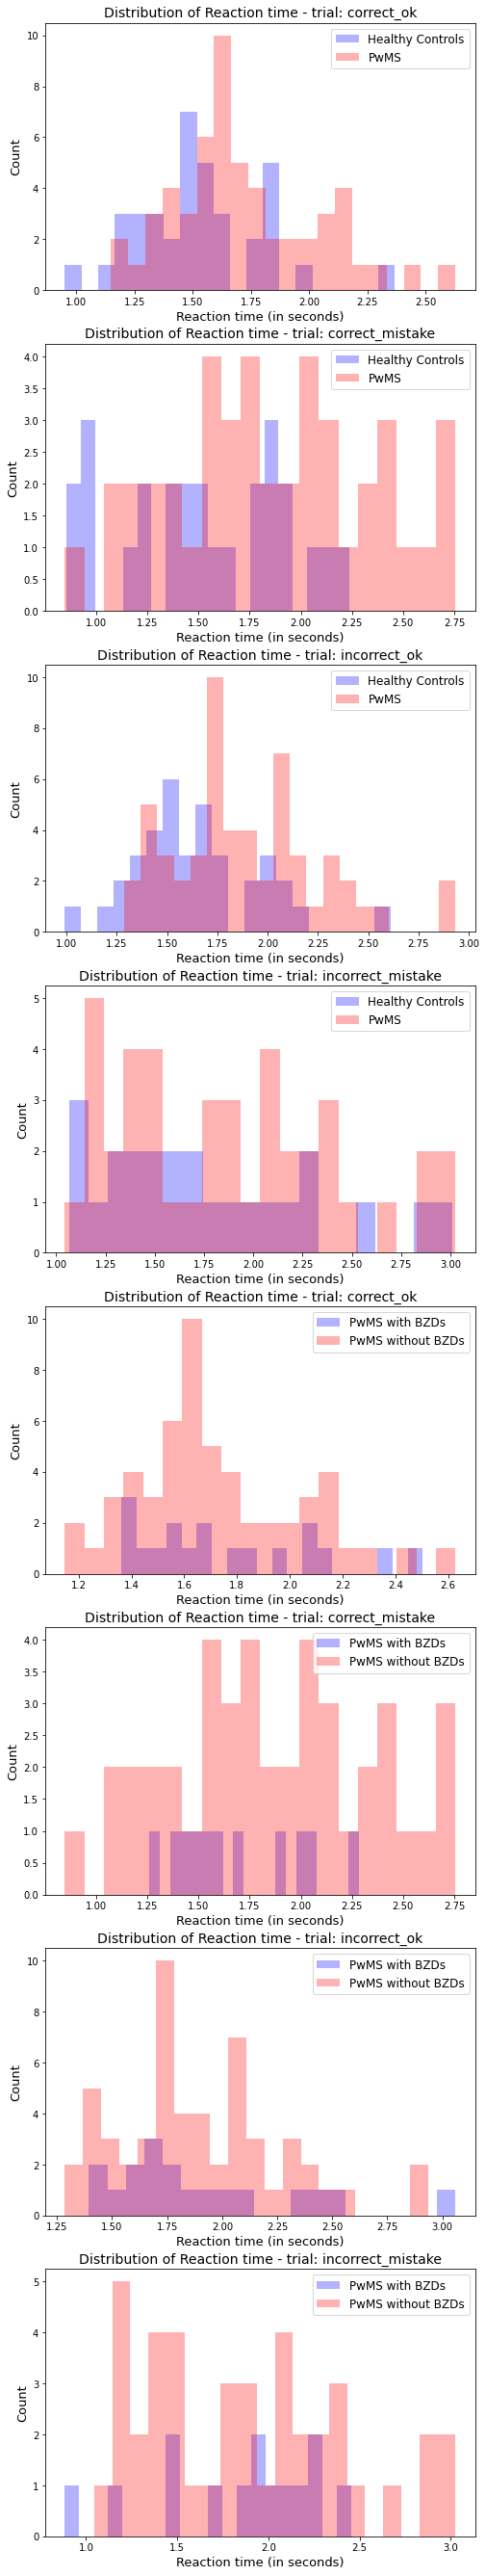

In [168]:
groups_vs = 2
types = 4
num_cases = groups_vs*types

fig, axes = plt.subplots(nrows=num_cases, ncols=1, figsize=(8, 6*num_cases))

group_names = ['Healthy Controls', 'PwMS', 'PwMS with BZDs', 'PwMS without BZDs']
event_types = ['correct_ok','correct_mistake','incorrect_ok','incorrect_mistake']

# for control vs. ms & 
for i in range(groups_vs):
    for j in range(types):
        ax = axes[i*types+j]
        
        data_group1 = rt_allgroups[2*i][j]
        data_group2 = rt_allgroups[2*1 + 1][j]
        
        # Filter out empty sub-arrays -> when sometimes no events were found per patient
        data_group1 = [subarray for subarray in data_group1 if subarray]
        data_group2 = [subarray for subarray in data_group2 if subarray]
        
        # Plot the histogram for OPEN EYES
        ax.hist(data_group1, bins=20, color='blue', alpha=0.3, label = group_names[2*i])
        ax.hist(data_group2, bins=20, color='red', alpha=0.3, label = group_names[2*i + 1])
        # Set labels and title for the subplot
        ax.set_xlabel('Reaction time (in seconds)', fontsize=13)
        ax.set_ylabel('Count', fontsize=13)
        ax.set_title(f'Distribution of Reaction time - trial: {event_types[j]}',fontsize=14)
        ax.legend(fontsize=12)

In [159]:
groups_vs = 2
types = 4

group_names = ['Healthy Controls', 'PwMS', 'PwMS with BZDs', 'PwMS without BZDs']
event_types = ['correct_ok','correct_mistake','incorrect_ok','incorrect_mistake']

# for control vs. ms & 
for i in range(groups_vs):
    
    print("\n######################################")
    print(group_names[2*i],  'vs.', group_names[2*i + 1])
    print("######################################")
    
    for j in range(types):
        
        print('Eventtype:', event_types[j])
        data_group1 = rt_allgroups[2*i][j]
        data_group2 = rt_allgroups[2*1 + 1][j]
    
        # Filter out empty sub-arrays -> when sometimes no events were found per patient
        data_group1 = [subarray for subarray in data_group1 if subarray]
        data_group2 = [subarray for subarray in data_group2 if subarray]
        
        print(group_names[2*i], np.mean(data_group1), '+/-', np.std(data_group1))
        print(group_names[2*i + 1], np.mean(data_group2), '+/-', np.std(data_group2))
        
        # independent t-test
        _, p_value = stats.ttest_ind(data_group1, data_group2) 
        print('p:', p_value)
        
        print('----------------------------')


######################################
Healthy Controls vs. PwMS
######################################
Eventtype: correct_ok
Healthy Controls 1.5257199467715217 +/- 0.27077443078592106
PwMS 1.7280151750021697 +/- 0.3106898653405865
p: 0.0019780818276119946
----------------------------
Eventtype: correct_mistake
Healthy Controls 1.5211384615384618 +/- 0.398311400285798
PwMS 1.8579700258397933 +/- 0.47780094620548846
p: 0.004103152840802504
----------------------------
Eventtype: incorrect_ok
Healthy Controls 1.6468120287647614 +/- 0.31010399058846627
PwMS 1.8947467101668583 +/- 0.3630514111320868
p: 0.0011265682594302413
----------------------------
Eventtype: incorrect_mistake
Healthy Controls 1.776527777777778 +/- 0.5336371696743253
PwMS 1.8789384250669965 +/- 0.5423151837527421
p: 0.46747386211054265
----------------------------

######################################
PwMS with BZDs vs. PwMS without BZDs
######################################
Eventtype: correct_ok
PwMS with BZDs 1.

### **Case 2**: NO mean -> flatten all rt's for each event per subject -> take all into account for group analysis

#### **Main conclusion**: The data distribution is skewed ==> Not justified to use a statistical test that assumes an approximate Normal distribution

In [169]:
rt_control = get_reaction_times(all_subject_dfs,IDs_control, inter_subject_mean = False)
rt_ms = get_reaction_times(all_subject_dfs,IDs_ms, inter_subject_mean = False)
rt_ms_yes_bzds = get_reaction_times(all_subject_dfs,IDs_ms_yes_bzds, inter_subject_mean = False)
rt_ms_no_bzds = get_reaction_times(all_subject_dfs,IDs_ms_no_bzds, inter_subject_mean = False)

rt_allgroups = [rt_control, rt_ms, rt_ms_yes_bzds, rt_ms_no_bzds]

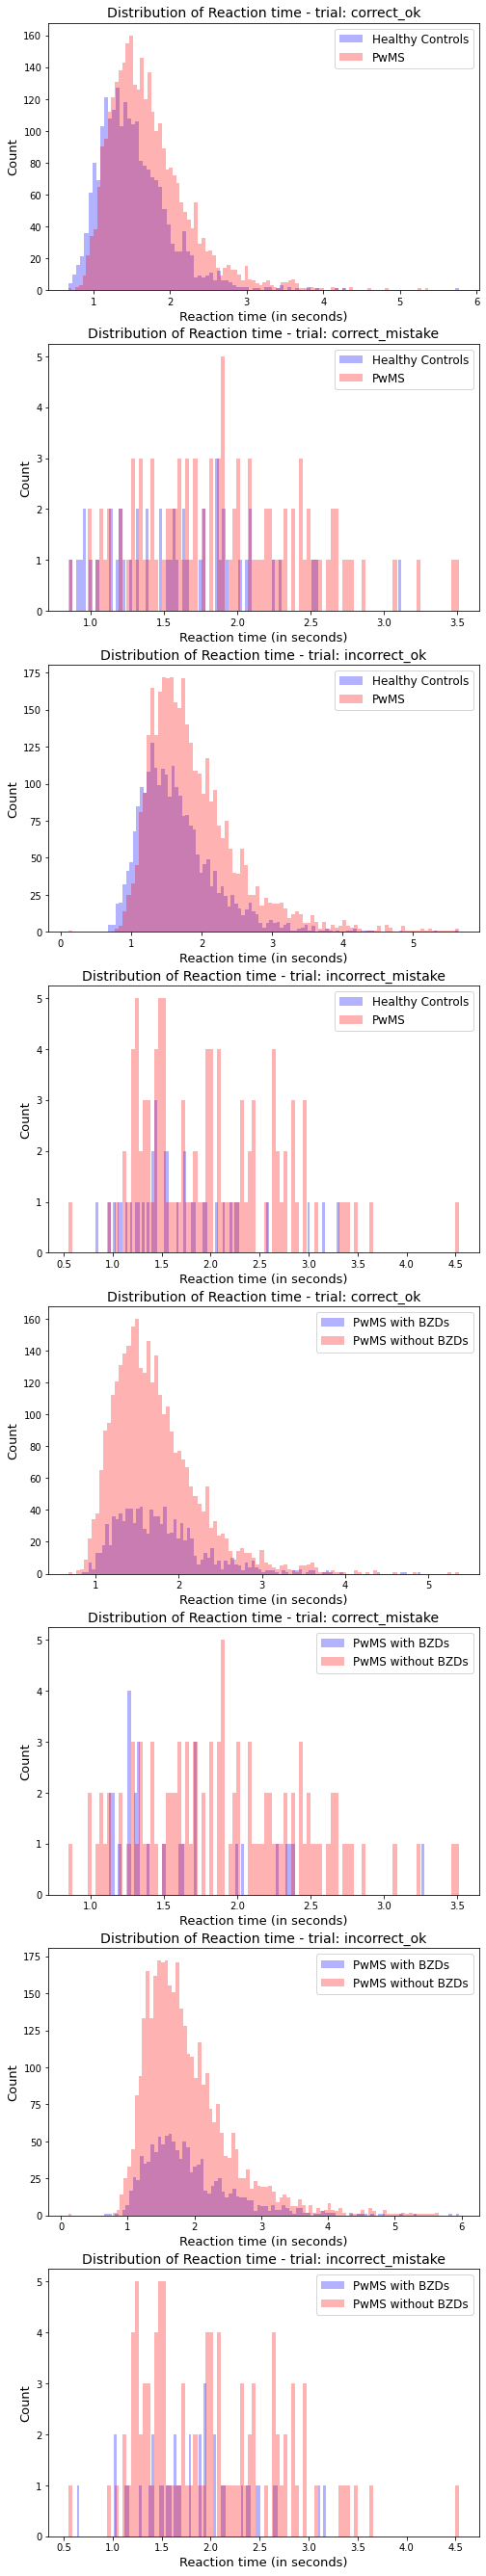

In [170]:
groups_vs = 2
types = 4
num_cases = groups_vs*types

fig, axes = plt.subplots(nrows=num_cases, ncols=1, figsize=(8, 6*num_cases))

group_names = ['Healthy Controls', 'PwMS', 'PwMS with BZDs', 'PwMS without BZDs']
event_types = ['correct_ok','correct_mistake','incorrect_ok','incorrect_mistake']

# for control vs. ms & 
for i in range(groups_vs):
    for j in range(types):
        ax = axes[i*types+j]
    
        data_group1 = rt_allgroups[2*i][j]
        data_group2 = rt_allgroups[2*1 + 1][j]
    
        # Filter out empty sub-arrays -> when sometimes no events were found per patient
        data_group1 = [subarray for subarray in data_group1 if subarray]
        data_group2 = [subarray for subarray in data_group2 if subarray]
    
        # Plot the histogram for OPEN EYES
        ax.hist(data_group1, bins=100, color='blue', alpha=0.3, label = group_names[2*i])
        ax.hist(data_group2, bins=100, color='red', alpha=0.3, label = group_names[2*i + 1])
        # Set labels and title for the subplot
        ax.set_xlabel('Reaction time (in seconds)', fontsize=13)
        ax.set_ylabel('Count', fontsize=13)
        ax.set_title(f'Distribution of Reaction time - trial: {event_types[j]}',fontsize=14)
        ax.legend(fontsize=12)

In [171]:
groups_vs = 2
types = 4

group_names = ['Healthy Controls', 'PwMS', 'PwMS with BZDs', 'PwMS without BZDs']
event_types = ['correct_ok','correct_mistake','incorrect_ok','incorrect_mistake']

# for control vs. ms & 
for i in range(groups_vs):
    
    print("\n######################################")
    print(group_names[2*i],  'vs.', group_names[2*i + 1])
    print("######################################")
    
    for j in range(types):
        
        print('Eventtype:', event_types[j])
        data_group1 = rt_allgroups[2*i][j]
        data_group2 = rt_allgroups[2*1 + 1][j]
    
        # Filter out empty sub-arrays -> when sometimes no events were found per patient
        data_group1 = [subarray for subarray in data_group1 if subarray]
        data_group2 = [subarray for subarray in data_group2 if subarray]
        
        print(group_names[2*i], np.mean(data_group1), '+/-', np.std(data_group1))
        print(group_names[2*i + 1], np.mean(data_group2), '+/-', np.std(data_group2))
        
        # independent t-test (as the 2 groups are from different populations)
        _, p_value = stats.ttest_ind(data_group1, data_group2) 
        print('p:', p_value)
        
        print('----------------------------')


######################################
Healthy Controls vs. PwMS
######################################
Eventtype: correct_ok
Healthy Controls 1.5246286231884059 +/- 0.455655066487245
PwMS 1.7227217766810612 +/- 0.523552450208417
p: 2.1337311165434927e-46
----------------------------
Eventtype: correct_mistake
Healthy Controls 1.6093617021276598 +/- 0.4834586574122859
PwMS 1.9194455445544552 +/- 0.5681101635472592
p: 0.0016101392025167772
----------------------------
Eventtype: incorrect_ok
Healthy Controls 1.6465885245901641 +/- 0.5480430590951895
PwMS 1.8906890005583474 +/- 0.6613539036814907
p: 2.9666782359768243e-50
----------------------------
Eventtype: incorrect_mistake
Healthy Controls 1.7073333333333336 +/- 0.5987613139733654
PwMS 1.9906138613861386 +/- 0.7079811902504586
p: 0.03520842013250446
----------------------------

######################################
PwMS with BZDs vs. PwMS without BZDs
######################################
Eventtype: correct_ok
PwMS with BZDs 1.

### Extra Case 2: **Transform the data (because highly skewed) using log()**, and then get p_value from independent t-test

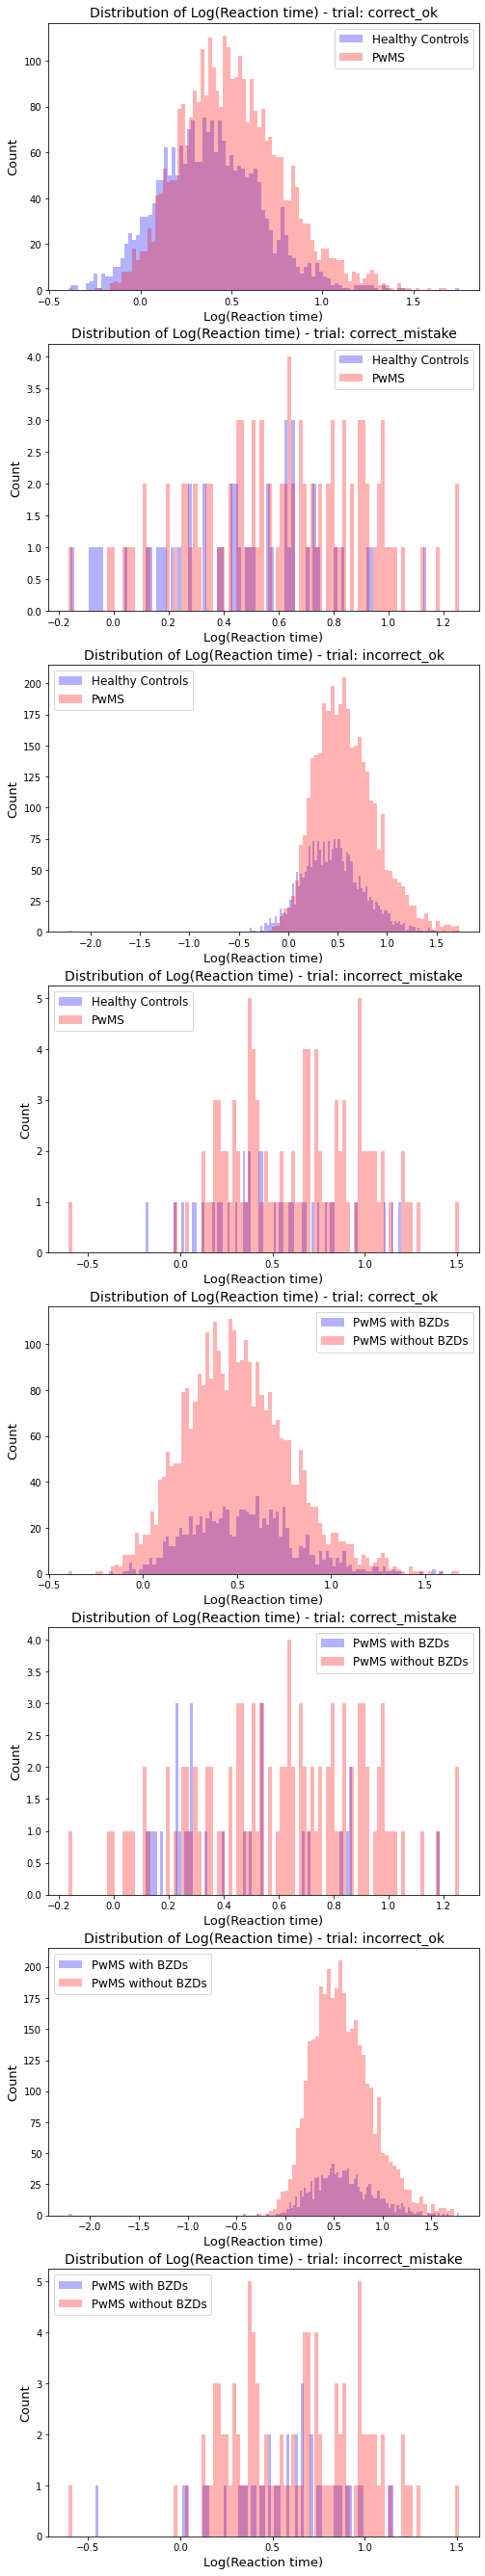

In [172]:
groups_vs = 2
types = 4
num_cases = groups_vs*types

fig, axes = plt.subplots(nrows=num_cases, ncols=1, figsize=(8, 6*num_cases))

group_names = ['Healthy Controls', 'PwMS', 'PwMS with BZDs', 'PwMS without BZDs']
event_types = ['correct_ok','correct_mistake','incorrect_ok','incorrect_mistake']

# for control vs. ms & 
for i in range(groups_vs):
    for j in range(types):
        ax = axes[i*types+j]
    
        data_group1 = np.log(rt_allgroups[2*i][j])
        data_group2 = np.log(rt_allgroups[2*1 + 1][j])
    
        # Filter out empty sub-arrays -> when sometimes no events were found per patient
        data_group1 = [subarray for subarray in data_group1 if subarray]
        data_group2 = [subarray for subarray in data_group2 if subarray]
        
        # Plot the histogram for OPEN EYES
        ax.hist(data_group1, bins=100, color='blue', alpha=0.3, label = group_names[2*i])
        ax.hist(data_group2, bins=100, color='red', alpha=0.3, label = group_names[2*i + 1])
        # Set labels and title for the subplot
        ax.set_xlabel('Log(Reaction time)', fontsize=13)
        ax.set_ylabel('Count', fontsize=13)
        ax.set_title(f'Distribution of Log(Reaction time) - trial: {event_types[j]}',fontsize=14)
        ax.legend(fontsize=12)

In [173]:
groups_vs = 2
types = 4

group_names = ['Healthy Controls', 'PwMS', 'PwMS with BZDs', 'PwMS without BZDs']
event_types = ['correct_ok','correct_mistake','incorrect_ok','incorrect_mistake']

# for control vs. ms & 
for i in range(groups_vs):
    
    print("\n######################################")
    print(group_names[2*i],  'vs.', group_names[2*i + 1])
    print("######################################")
    
    for j in range(types):
        
        print('Eventtype:', event_types[j])
        data_group1 = np.log(rt_allgroups[2*i][j])
        data_group2 = np.log(rt_allgroups[2*1 + 1][j])
    
        # Filter out empty sub-arrays -> when sometimes no events were found per patient
        data_group1 = [subarray for subarray in data_group1 if subarray]
        data_group2 = [subarray for subarray in data_group2 if subarray]
        
        print(group_names[2*i], np.mean(data_group1), '+/-', np.std(data_group1))
        print(group_names[2*i + 1], np.mean(data_group2), '+/-', np.std(data_group2))
        
        # independent t-test (as the 2 groups are from different populations)
        _, p_value = stats.ttest_ind(data_group1, data_group2) 
        print('p:', p_value)
        
        print('----------------------------')


######################################
Healthy Controls vs. PwMS
######################################
Eventtype: correct_ok
Healthy Controls 0.38323077512335246 +/- 0.27628796115237686
PwMS 0.5038321485264874 +/- 0.2785575646874807
p: 1.619436130798289e-54
----------------------------
Eventtype: correct_mistake
Healthy Controls 0.4406130377338181 +/- 0.2964748307997093
PwMS 0.6073089809282078 +/- 0.3028929794366714
p: 0.002375864372230633
----------------------------
Eventtype: incorrect_ok
Healthy Controls 0.4508906772884513 +/- 0.30551426302369394
PwMS 0.585397829635899 +/- 0.31386969502479767
p: 8.630090153074512e-60
----------------------------
Eventtype: incorrect_mistake
Healthy Controls 0.4788116326153305 +/- 0.33033152289417417
PwMS 0.6259763656122503 +/- 0.357043716368446
p: 0.03342526094931238
----------------------------

######################################
PwMS with BZDs vs. PwMS without BZDs
######################################
Eventtype: correct_ok
PwMS with BZDs 

### Extra Case 2: Use non-parametric tests --> Mann-Whitney U test (for two independent samples) --> **These results are reported in the Thesis**

In [174]:
from scipy.stats import mannwhitneyu
groups_vs = 2
types = 4

group_names = ['Healthy Controls', 'PwMS', 'PwMS with BZDs', 'PwMS without BZDs']
event_types = ['correct_ok','correct_mistake','incorrect_ok','incorrect_mistake']

# for control vs. ms & 
for i in range(groups_vs):
    
    print("\n######################################")
    print(group_names[2*i],  'vs.', group_names[2*i + 1])
    print("######################################")
    
    for j in range(types):
        
        print('Eventtype:', event_types[j])
        data_group1 = rt_allgroups[2*i][j]
        data_group2 = rt_allgroups[2*1 + 1][j]
    
        # Filter out empty sub-arrays -> when sometimes no events were found per patient
        data_group1 = [subarray for subarray in data_group1 if subarray]
        data_group2 = [subarray for subarray in data_group2 if subarray]
        
        print(group_names[2*i], np.mean(data_group1), '+/-', np.std(data_group1))
        print(group_names[2*i + 1], np.mean(data_group2), '+/-', np.std(data_group2))
        
        # independent t-test (as the 2 groups are from different populations)
        _, p_value = stats.mannwhitneyu(data_group1, data_group2) 
        print('p:', p_value)
        
        print('----------------------------')


######################################
Healthy Controls vs. PwMS
######################################
Eventtype: correct_ok
Healthy Controls 1.5246286231884059 +/- 0.455655066487245
PwMS 1.7227217766810612 +/- 0.523552450208417
p: 4.924321122136766e-51
----------------------------
Eventtype: correct_mistake
Healthy Controls 1.6093617021276598 +/- 0.4834586574122859
PwMS 1.9194455445544552 +/- 0.5681101635472592
p: 0.0018586240953682228
----------------------------
Eventtype: incorrect_ok
Healthy Controls 1.6465885245901641 +/- 0.5480430590951895
PwMS 1.8906890005583474 +/- 0.6613539036814907
p: 1.6797933986943402e-56
----------------------------
Eventtype: incorrect_mistake
Healthy Controls 1.7073333333333336 +/- 0.5987613139733654
PwMS 1.9906138613861386 +/- 0.7079811902504586
p: 0.0291741599231116
----------------------------

######################################
PwMS with BZDs vs. PwMS without BZDs
######################################
Eventtype: correct_ok
PwMS with BZDs 1.77

## **Extra:** Mean Reaction Time for (2) (trial_correct_ok + trial_correct_mistake) and (trial_incorrect_ok + trial_incorrect_mistake) and **across all subjects**

**Note**: Those values are used in Notebook 5. HMM Analysis to decide on a sufficiently large time window for observing ERF-like state activations

In [51]:
from itertools import chain

## for the correct trials:
overall_RT_correct = list(chain.from_iterable([rt_control[0], rt_control[1], rt_ms[0], rt_ms[1]]))
print('overall RT correct MEAN: ', np.mean(overall_RT_correct))

## for the correct trials:
overall_RT_incorrect = list(chain.from_iterable([rt_control[2], rt_control[3], rt_ms[2], rt_ms[3]]))
print('overall RT incorrect MEAN: ', np.mean(overall_RT_incorrect))

overall RT correct MEAN:  1.6677168035847647
overall RT incorrect MEAN:  1.8139945666938333
